# CSE 398 Deep Learning Final Project
## Detecting Diabetic Retinopathy in Enhanced Retinal Fundus Images
### DeepNet Architecture Tests with Low-Quality and Enhanced Low-Quality Retinal Fundus Images

James Hoffmeister

### tdqm

We install TDQM to have progress bars while training. This helps understand how fast the models may train and validate data.

In [19]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os

train_dir = "./train"
reject_test_dir = "./test/original/Reject"
enhanced_test_dir = "./test/enhanced"

def check_data_directory(directory, name):
    if not os.path.exists(directory):
        print(f"ERROR: {name} directory '{directory}' does not exist.")
        return False
    elif not any(os.scandir(directory)):
        print(f"WARNING: {name} directory '{directory}' exists but is EMPTY.")
        return False
    else:
        print(f"{name} directory '{directory}' is ready.")
        return True

# Check all required directories
train_ready = check_data_directory(train_dir, "Training Data")
reject_ready = check_data_directory(reject_test_dir, "Reject Test Data (Original)")
enhanced_ready = check_data_directory(enhanced_test_dir, "Enhanced Reject Test Data")

# Optional: Exit if any critical directory is missing
if not (train_ready and reject_ready and enhanced_ready):
    raise RuntimeError("\nDataset check failed. Please make sure all required data folders have images before continuing.")
else:
    print("\nAll datasets are correctly prepared. Proceeding with model training/testing.")


Training Data directory './train' is ready.
Reject Test Data (Original) directory './test/original/Reject' is ready.
Enhanced Reject Test Data directory './test/enhanced' is ready.

All datasets are correctly prepared. Proceeding with model training/testing.


## Imports and Transforms

We define transforms thattranslate the original 512x512 image format into 224x224 imagenet standard for the DenseNet model. We also add some preprocessing to reduce overfitting.

In [3]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import WeightedRandomSampler
import torch
from collections import Counter

if torch.cuda.is_available:
  device = torch.device("cuda")
  print('Using CUDA')
else:
  device = torch.device("cpu")
  print('Could not use CUDA')

# image transform to DenseNet input architecture
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # random shift
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5), # simulate lens distortion
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

print("Transformers defined.")


/opt/tljh/user/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/tljh/user/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


Using CUDA
Transformers defined.


## Data Loading

We load the data from the directories using a filtered image folder object that detects only images that may be used for training and testing. We stratify the data before splitting it into training and validation subsets randomly. 

I am more used to Numpy than Torch so sometimes for tensor operations I default to Numpy.

In [4]:
# this was only necessary because magic had some invisible file
# in my folder that I had to tell the code to ignore ¯\_(ツ)_/¯
class FilteredImageFolder(ImageFolder):
    def find_classes(self, directory):
        # ignore the .ipynb file hidden in my train folder
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and not d.startswith('.')]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
# using imagefolder to extract data
dataset = FilteredImageFolder(root=train_dir, transform=None)

# stratified split
targets = dataset.targets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_id, val_id = next(splitter.split(np.zeros(len(targets)), targets))

# subsets
train_dataset = Subset(dataset, train_id)
val_dataset = Subset(dataset, val_id)

# add transformations
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

print("Subsets defined.")

Subsets defined.


## Weighted Sampling

We weight the sampler because the class distribution is heavily skewed to the class 0. We compute class weights as the inverse of class size before manually adjusting to desired sizes. Without this critical step, the model would only ever learn class 0.

In [5]:
# weighted sampler to deal with class imbalance

train_targets = torch.tensor([dataset.targets[i] for i in train_dataset.indices], device=device)
num_classes = train_targets.max().item() + 1
class_counts = torch.bincount(train_targets, minlength=num_classes)
class_weights_per_class = 1. / (class_counts.float() ** 0.5)
class_weights_per_class[0] *= 0.5
class_weights_per_class[1] *= 3
class_weights_per_class[3] *= 3
class_weights_per_class[2] *= 2
samples_weight = class_weights_per_class[train_targets]
sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

# load data
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

print("Data loaders prepared.")

Data loaders prepared.


## Model Definition

We choose DenseNet121 for this test. This is considerably larger than the other models being trained for this experiment. It is also similar to one of the models used in the original paper that developed the EyeQ dataset. We freeze all but a few of the layers (denseblock4, norm5, classifier). The classifier has dropout to ensure there is no overfitting. 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# load densenet121 pretrained model
model = models.densenet121(weights='IMAGENET1K_V1')
num_ftrs = model.classifier.in_features
# added dropout to fix overfitting
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier.in_features, 5)  # 0-4
)

# freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# unfreeze denseblock4, classifier (last few layers)
for name, param in model.features.denseblock4.named_parameters():
    param.requires_grad = True

for name, param in model.features.norm5.named_parameters():
    param.requires_grad = True

for name, param in model.classifier.named_parameters():
    param.requires_grad = True
    
trainable_params = filter(lambda p: p.requires_grad, model.parameters())

model = model.to(device)

print("Model defined.")

Model defined.


## Loss, Optimizer, and Scheduler

We use focal loss and the Adam optimizer. Focal loss is used because of the underrepresented classes 1 and 3. We use a Cosine-Annealing Learning Rate scheduler to smoothly decrease learning rate over time.

In [7]:
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, num_classes=5):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        #calculate cross entropy loss
        ce_loss = self.ce_loss(inputs, targets)
        # compute probability of correct class
        pt = torch.exp(-ce_loss)
        # focal loss
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean()  # return the mean loss


# using cross-entropy loss, pretty standard
criterion = FocalLoss(alpha=0.25, gamma=2, num_classes=5)

# using an ADAM optimizer, mentioned in lecture
# also regularizing with weight decay since initial tests showed heavy overfitting
optimizer = optim.Adam(trainable_params, lr=1e-4, weight_decay=1e-4)

# scheduler to bring down learning rate to reduce overfitting
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4)

print("Loss, Optimizer, and Scheduler defined.")

Loss, Optimizer, and Scheduler defined.


## Model Training

We train the model for a total of 7 epochs on the training data. 


Epoch [1/4] - Train Loss: 30.2946, Train Acc: 0.4380


Validation Acc: 0.2977
Accuracy for class 0: 21.86%
Accuracy for class 1: 39.01%
Accuracy for class 2: 62.15%
Accuracy for class 3: 40.30%
Accuracy for class 4: 40.00%



Epoch [2/4] - Train Loss: 17.8628, Train Acc: 0.6237


Validation Acc: 0.4141
Accuracy for class 0: 38.47%
Accuracy for class 1: 50.00%
Accuracy for class 2: 51.66%
Accuracy for class 3: 35.82%
Accuracy for class 4: 52.00%



Epoch [3/4] - Train Loss: 11.2211, Train Acc: 0.7599


Validation Acc: 0.4508
Accuracy for class 0: 43.94%
Accuracy for class 1: 35.71%
Accuracy for class 2: 59.12%
Accuracy for class 3: 29.85%
Accuracy for class 4: 40.00%



Epoch [4/4] - Train Loss: 8.3757, Train Acc: 0.8092


Validation Acc: 0.4874
Accuracy for class 0: 49.35%
Accuracy for class 1: 25.27%
Accuracy for class 2: 61.33%
Accuracy for class 3: 29.85%
Accuracy for class 4: 46.00%


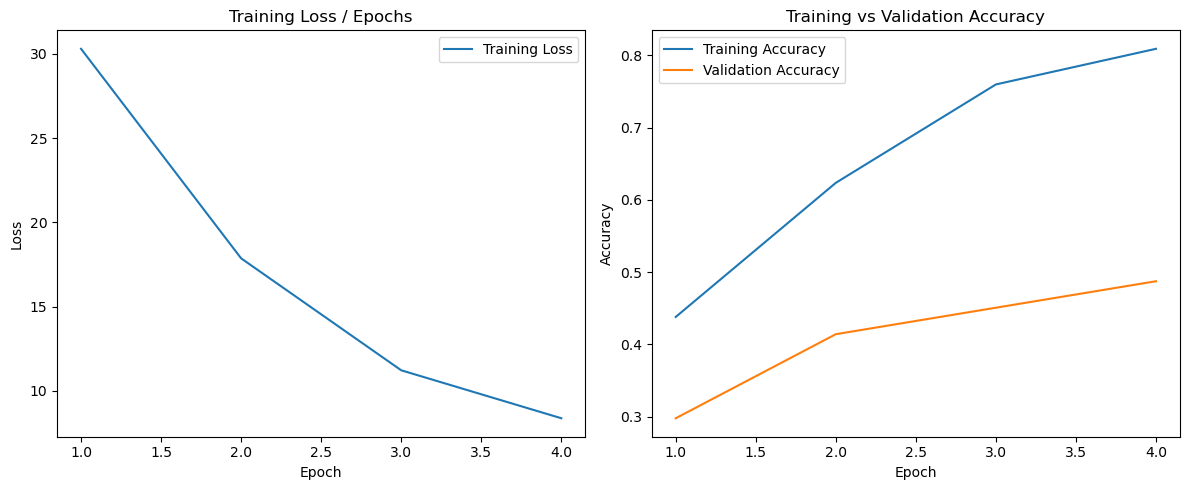

In [8]:
from sklearn.metrics import confusion_matrix
import numpy as np
from tqdm import tqdm  # progress bars
import matplotlib.pyplot as plt # inspied by hw2

# training loop
def train(model, train_loader, val_loader, optimizer, scheduler, verbose, epochs):
    
    # for plotting, thanks hw2
    train_losses = []
    val_accuracies = []
    train_accuracies = []
    
    # for number of epochs
    for epoch in range(epochs):
        # switch model to train mode
        model.train()
        # vars for recording
        total_loss = 0.0
        correct = 0
        total = 0

        # loading bar for easy timing
        batch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False) if verbose else train_loader

        # for each image in each batch
        for images, labels in batch_iterator:
            images = images.to(device)
            labels = labels.to(device)

            # forward pass and loss calculation
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # total loss calculation and prediction summation
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # update loading bar
            if verbose: batch_iterator.set_postfix(loss=loss.item()) 

        # calculate accuracy and print
        train_acc = correct / total
        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        print(f"\nEpoch [{epoch+1}/{epochs}] - Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}")

        # validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        val_iterator = tqdm(val_loader, desc=f"Validating {epoch+1}/{epochs}", leave=False) if verbose else val_loader
        
        all_preds = []
        all_labels = []
        
        correct_per_class = torch.zeros(5)
        total_per_class = torch.zeros(5)
        
        with torch.no_grad():
            # for each image in validation set
            for images, labels in val_iterator:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # classwise accuracy
                for label, pred in zip(labels, predicted):
                    total_per_class[label] += 1
                    if label == pred:
                        correct_per_class[label] += 1
                
                if verbose: val_iterator.set_postfix(loss=loss.item())

        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)
        print(f"Validation Acc: {val_acc:.4f}")
        
        for i in range(5):
            if total_per_class[i] > 0:
                acc = 100 * correct_per_class[i] / total_per_class[i]
                print(f"Accuracy for class {i}: {acc:.2f}%")
            else:
                print(f"Class {i} has no samples.")
    
        # step the scheduler to reduce learning rate
        avg_val_loss = val_loss / len(val_iterator)

        # step the scheduler
        scheduler.step()
        
    return train_losses, train_accuracies, val_accuracies


train_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, optimizer, scheduler, verbose=True, epochs=4)
epochs_range = range(1, len(train_losses)+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss / Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('DenseNet_training.png', bbox_inches='tight')
plt.show()


## Train Time Analysis

The model heavily overfits to class 0. Despite repeated efforts to mitigate memorization of class 0 features and introduce bias toward underrepresented classes 1 and 3, the model continues to reduce its accuracy for underrepresented classes while overemphasizing overrepresented classes. Despite the use of focal loss and weighted sampling, the skew remains. Note that validation set accuracy is heavily dependant on class 0 accuracy because of the large skew toward class 0 in validation set sampling. Currently selected hyperparameters of lr=1e-4 and weight_decay=1e-4 are considered to be optimal.

In [9]:
model_path = "DenseNetModelFinal.pth"
torch.save(model.state_dict(), model_path)

## Testing Data Import

We import two testing sets: reject and enhanced reject images.

In [10]:
import pandas as pd # for CSV from EyeQ dataset
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# test image loader
class TestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        df = pd.read_csv(csv_file)
        
        # necessary since enhanced images are PNG and rejects are jpeg
        def find_existing_file(image_name):
            base_name = os.path.splitext(image_name)[0]
            for ext in ['.jpeg', '.png']:
                candidate = os.path.join(root_dir, base_name + ext)
                if os.path.exists(candidate):
                    return candidate
            return None

        # keep only rows with images in the directory
        df['full_path'] = df['image'].apply(find_existing_file)
        df = df[df['full_path'].notnull()]

        # reset index
        self.annotations = df.reset_index(drop=True)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        # get image path
        img_path = self.annotations.iloc[index]['full_path']
        # convert image to RGB
        image = Image.open(img_path).convert("RGB")
        # add label according to EyeQ dataset
        label = self.annotations.iloc[index]['DR_grade']

        # transform
        if self.transform:
            image = self.transform(image)

        return image, label



We transform the images to the ImageNet standard for use with the DeepNet model. Using original image sizes would make training too computationally heavy.

In [11]:

# transform to imagenet standard
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # imagenet size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# load reject images (all quality 0)
reject_test_dataset = TestDataset(csv_file='Label_EyeQ_test.csv', root_dir=reject_test_dir, transform=test_transforms)
reject_test_loader = DataLoader(reject_test_dataset, batch_size=64, shuffle=False)

# load images enhanced with Cofe-Net
enhanced_test_dataset = TestDataset(csv_file='Label_EyeQ_test.csv', root_dir=enhanced_test_dir, transform=test_transforms)
enhanced_test_loader = DataLoader(enhanced_test_dataset, batch_size=64, shuffle=False)

print("Test sets defined.")

Test sets defined.


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

reject_labels = reject_test_dataset.annotations['DR_grade']
reject_class_counts = reject_labels.value_counts().sort_index()

enhanced_labels = enhanced_test_dataset.annotations['DR_grade']
enhanced_class_counts = enhanced_labels.value_counts().sort_index()


## Original Reject Quality Image Test

We test the original reject quality images to find accuracy as well as classwise accuracy, precision, recall, F1, AUC, and confusion matrix.

Reject Test Acc: 0.4409
Accuracy for class 0: 45.11%
Accuracy for class 1: 11.11%
Accuracy for class 2: 54.19%
Accuracy for class 3: 4.81%
Accuracy for class 4: 50.51%

Classification Report:
              precision    recall  f1-score   support

           0     0.8021    0.4511    0.5774      2166
           1     0.0714    0.1111    0.0870       153
           2     0.2138    0.5419    0.3066       561
           3     0.1000    0.0481    0.0649       104
           4     0.3937    0.5051    0.4425       198

    accuracy                         0.4409      3182
   macro avg     0.3162    0.3314    0.2957      3182
weighted avg     0.6149    0.4409    0.4809      3182

AUC Score (macro average): 0.5854


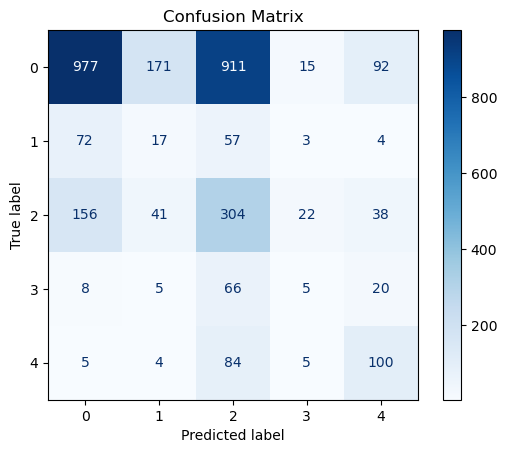

In [13]:

model.eval()
reject_all_preds = []
reject_all_labels = []

reject_correct_per_class = torch.zeros(5)
reject_total_per_class = torch.zeros(5)

with torch.no_grad():
    reject_test_iterator = tqdm(reject_test_loader, desc="Testing reject images...", leave=False)
    reject_test_correct = 0
    reject_test_total = 0
    for images, labels in reject_test_iterator:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # classwise accuracy
        for label, pred in zip(labels, preds):
            reject_total_per_class[label] += 1
            if label == pred:
                reject_correct_per_class[label] += 1
        
        reject_test_total += labels.size(0)
        reject_test_correct += (preds == labels).sum().item()

        reject_all_preds.extend(preds.cpu().numpy())
        reject_all_labels.extend(labels.cpu().numpy())

reject_test_accuracy = reject_test_correct / reject_test_total
print(f"Reject Test Acc: {reject_test_accuracy:.4f}")

rej_test_class_acc = []
for i in range(5):
    if reject_total_per_class[i] > 0:
        acc = 100 * reject_correct_per_class[i] / reject_total_per_class[i]
        rej_test_class_acc.append(acc)
        print(f"Accuracy for class {i}: {acc:.2f}%")
    else:
        print(f"Class {i} has no samples.")
        
# classification report contains precision, recall, and F1 score
print("\nClassification Report:")
print(classification_report(reject_all_labels, reject_all_preds, digits=4))
        
try:
    # AUC
    from sklearn.preprocessing import label_binarize
    reject_all_labels_onehot = label_binarize(reject_all_labels, classes=[0, 1, 2, 3, 4])
    reject_all_preds_onehot = label_binarize(reject_all_preds, classes=[0, 1, 2, 3, 4])

    reject_auc = roc_auc_score(reject_all_labels_onehot, reject_all_preds_onehot, average="macro", multi_class="ovo")
    print(f"AUC Score (macro average): {reject_auc:.4f}")
except Exception as e:
    print(f"Could not compute AUC: {e}")

reject_cm = confusion_matrix(reject_all_labels, reject_all_preds)
reject_disp = ConfusionMatrixDisplay(confusion_matrix=reject_cm, display_labels=[0, 1, 2, 3, 4])
reject_disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('Confusion Matrix: DenseNet121 Original Reject Quality Images.png', bbox_inches='tight')
plt.show()

## Enhanced Reject Quality Image Test

We test the enhanced reject quality images to find accuracy as well as classwise accuracy, precision, recall, F1, AUC, and confusion matrix.

Enhanced Test Acc: 0.4136
Accuracy for class 0: 41.04%
Accuracy for class 1: 12.42%
Accuracy for class 2: 59.00%
Accuracy for class 3: 5.77%
Accuracy for class 4: 35.86%

Classification Report:
              precision    recall  f1-score   support

           0     0.8002    0.4104    0.5426      2166
           1     0.0782    0.1242    0.0960       153
           2     0.2166    0.5900    0.3169       561
           3     0.1091    0.0577    0.0755       104
           4     0.2898    0.3586    0.3205       198

    accuracy                         0.4136      3182
   macro avg     0.2988    0.3082    0.2703      3182
weighted avg     0.6082    0.4136    0.4522      3182

AUC Score (macro average): 0.5718


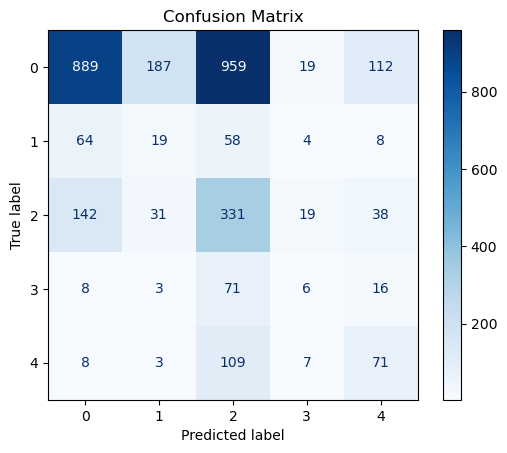

In [14]:
model.eval()
enhanced_all_preds = []
enhanced_all_labels = []

enhanced_correct_per_class = torch.zeros(5)
enhanced_total_per_class = torch.zeros(5)

with torch.no_grad():
    enhanced_test_iterator = tqdm(enhanced_test_loader, desc="Testing enhanced images...", leave=False)
    enhanced_test_correct = 0
    enhanced_test_total = 0
    for images, labels in enhanced_test_iterator:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # classwise accuracy
        for label, pred in zip(labels, preds):
            enhanced_total_per_class[label] += 1
            if label == pred:
                enhanced_correct_per_class[label] += 1
        
        enhanced_test_total += labels.size(0)
        enhanced_test_correct += (preds == labels).sum().item()

        enhanced_all_preds.extend(preds.cpu().numpy())
        enhanced_all_labels.extend(labels.cpu().numpy())

enhanced_test_accuracy = enhanced_test_correct / enhanced_test_total
print(f"Enhanced Test Acc: {enhanced_test_accuracy:.4f}")

enh_test_class_acc = []
for i in range(5):
    if enhanced_total_per_class[i] > 0:
        acc = 100 * enhanced_correct_per_class[i] / enhanced_total_per_class[i]
        enh_test_class_acc.append(acc)
        print(f"Accuracy for class {i}: {acc:.2f}%")
    else:
        print(f"Class {i} has no samples.")
        
# classification report contains precision, recall, and F1 score
print("\nClassification Report:")
print(classification_report(enhanced_all_labels, enhanced_all_preds, digits=4))
        
try:
    # AUC
    from sklearn.preprocessing import label_binarize
    enhanced_all_labels_onehot = label_binarize(enhanced_all_labels, classes=[0, 1, 2, 3, 4])
    enhanced_all_preds_onehot = label_binarize(enhanced_all_preds, classes=[0, 1, 2, 3, 4])

    enhanced_auc = roc_auc_score(enhanced_all_labels_onehot, enhanced_all_preds_onehot, average="macro", multi_class="ovo")
    print(f"AUC Score (macro average): {enhanced_auc:.4f}")
except Exception as e:
    print(f"Could not compute AUC: {e}")

enhanced_cm = confusion_matrix(enhanced_all_labels, enhanced_all_preds)
enhanced_disp = ConfusionMatrixDisplay(confusion_matrix=enhanced_cm, display_labels=[0, 1, 2, 3, 4])
enhanced_disp.plot(cmap='Blues')
plt.title('Confusion Matrix: DenseNet121 Enhanced Reject Quality Images')
plt.savefig('DenseNet_enhanced_confmat.png', bbox_inches='tight')
plt.show()

## Evaluation

The main difference in classwise accuracy comes from Class 0 images, those which do not show signs of Diabetic Retinopathy. More of these images are incorrectly labeled as Class 2 and Class 4 in the Enhanced tests compared to the Original tests, as shown in the confusion matrixes. 

In [15]:

from scipy import stats

reject_f1_per_class = f1_score(reject_all_labels, reject_all_preds, labels=[0, 1, 2, 3, 4], average=None)
enhanced_f1_per_class = f1_score(enhanced_all_labels, enhanced_all_preds, labels=[0, 1, 2, 3, 4], average=None)

t_stat, p_value = stats.ttest_rel(enhanced_f1_per_class, reject_f1_per_class)

print(f"F1 Paired t-test result: t-stat = {t_stat:.4f}, p-value = {p_value:.4f}")


F1 Paired t-test result: t-stat = -0.9900, p-value = 0.3782
